In [16]:
import mysql.connector
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os



In [34]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

DB_HOST = "localhost"
print(f"Connecting to host: {DB_HOST}")  # Debug
# Get DB credentials from environment variables
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
#DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT") or 3306)
DB_NAME = os.getenv("DB_NAME")
print(f"DB_USER='{DB_USER}'")
print(f"DB_PASSWORD='{DB_PASSWORD}'")
print(f"DB_HOST='{DB_HOST}'")
print(f"DB_PORT='{DB_PORT}'")
print(f"DB_NAME='{DB_NAME}'")

from urllib.parse import quote_plus

password_encoded = quote_plus(DB_PASSWORD)
engine = create_engine(f"mysql+pymysql://{DB_USER}:{password_encoded}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

conn = engine.connect()

print("✅ Database connection successful.")

Connecting to host: localhost
DB_USER='root'
DB_PASSWORD='12345678'
DB_HOST='localhost'
DB_PORT='3306'
DB_NAME='sakila'
✅ Database connection successful.


In [18]:
def clean_dataframe(df, table_name=None):
    """
    Removes missing values and duplicates from a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to clean.
        table_name (str): Optional, name of the table for logging purposes.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    original_shape = df.shape

    # Drop missing values
    df = df.dropna()

    # Drop duplicates
    df = df.drop_duplicates()

    cleaned_shape = df.shape

    if table_name:
        print(f"[{table_name}] Cleaned: {original_shape[0] - cleaned_shape[0]} rows removed")

    return df


In [44]:
# Simulated dirty rental data
test_df = pd.DataFrame([
    {'rental_id': 16000, 'rental_date': None, 'inventory_id': 1525, 'customer_id': 130, 'return_date': '2025-05-25 10:00:00'},
    {'rental_id': 16001, 'rental_date': '2025-05-23 12:00:00', 'inventory_id': 99999, 'customer_id': 130, 'return_date': '2025-05-24 13:00:00'},
    {'rental_id': 16002, 'rental_date': '2025-05-22 11:00:00', 'inventory_id': 1525, 'customer_id': 130, 'return_date': '2025-05-25 10:00:00'},
    {'rental_id': 16002, 'rental_date': '2025-05-22 11:00:00', 'inventory_id': 1525, 'customer_id': 130, 'return_date': '2025-05-25 10:00:00'},
# duplicate
])
dim_test_df = clean_dataframe(
    test_df[['rental_id', 'rental_date', 'inventory_id', 'customer_id', 'return_date']]
   
)
dim_test_df

,rental_id,rental_date,inventory_id,customer_id,return_date
1,16001,2025-05-23 12:00:00,99999,130,2025-05-24 13:00:00
2,16002,2025-05-22 11:00:00,1525,130,2025-05-25 10:00:00


In [19]:
# 1. dim_staff
dim_staff_query = "SELECT staff_id, first_name, last_name, store_id FROM staff"
dim_staff = pd.read_sql(dim_staff_query, engine)
dim_staff = clean_dataframe(dim_staff, table_name='dim_staff')
dim_staff.to_sql('dim_staff', con=engine, if_exists='append', index=False)
dim_staff


[dim_staff] Cleaned: 0 rows removed


,staff_id,first_name,last_name,store_id
0,1,Mike,Hillyer,1
1,2,Jon,Stephens,2


In [20]:
#film
dim_film_query = "SELECT film_id, title, release_year, language_id FROM film"
dim_film = pd.read_sql(dim_film_query, engine)
dim_film = clean_dataframe(dim_film, table_name='dim_film')
dim_film.to_sql('dim_film', con=engine, if_exists='append', index=False)


[dim_film] Cleaned: 0 rows removed


1000

In [21]:
#store
dim_store_query = "SELECT store_id, manager_staff_id, address_id FROM store"
dim_store = pd.read_sql(dim_store_query, engine)
dim_store = clean_dataframe(dim_store, table_name='dim_store')
dim_store.to_sql('dim_store', con=engine, if_exists='append', index=False)


[dim_store] Cleaned: 0 rows removed


2

In [22]:
# 1. dim_date
date_range = pd.date_range(start='2005-01-01', end='2006-12-31', freq='D')
dim_date = pd.DataFrame({
   'date_id': date_range.strftime('%Y%m%d').astype(int),
   'full_date': date_range,
   'month': date_range.month,
   'year': date_range.year,
})
dim_date = clean_dataframe(dim_date, table_name='dim_date')
dim_date.to_sql('dim_date', con=engine, if_exists='append', index=False)


[dim_date] Cleaned: 0 rows removed


730

In [23]:
# First, ensure all rental records are in dim_rental
rentals = pd.read_sql(
    "SELECT rental_id, rental_date, inventory_id, customer_id FROM rental", 
    engine
)
rentals = clean_dataframe(rentals, table_name='dim_rental')
rentals.to_sql('dim_rental', con=engine, if_exists='append', index=False)

# Then insert your fact table data


[dim_rental] Cleaned: 0 rows removed


16044

In [24]:
# Get rental and inventory data
rental_df = pd.read_sql("SELECT rental_id, rental_date, inventory_id FROM rental", engine)
inventory_df = pd.read_sql("SELECT inventory_id, film_id, store_id FROM inventory", engine)

# Merge rental with inventory
rental_inventory = rental_df.merge(inventory_df, on='inventory_id', how='inner')

# Convert rental_date to date_id format (YYYYMMDD)
rental_inventory['date_id'] = pd.to_datetime(rental_inventory['rental_date']).dt.strftime('%Y%m%d').astype(int)

# Group and count rentals per film-store-date as "inventory_count"
fact_daily_inventory_df = rental_inventory.groupby(
    ['date_id', 'film_id', 'store_id']
).size().reset_index(name='inventory_count')
fact_daily_inventory_df = clean_dataframe(fact_daily_inventory_df, table_name='fact_daily_inventory')
# Insert into your existing table
fact_daily_inventory_df.to_sql('fact_daily_inventory', con=engine, if_exists='append', index=False)


[fact_daily_inventory] Cleaned: 0 rows removed


14102

In [25]:

payments = pd.read_sql("SELECT staff_id, rental_id, payment_date, amount FROM payment", engine)
payments['payment_date'] = pd.to_datetime(payments['payment_date'])
payments['year'] = payments['payment_date'].dt.year
payments['month'] = payments['payment_date'].dt.month
payments['date_id'] = (payments['year'] * 10000 + payments['month'] * 100 + 1).astype(int)

# Group by staff, rental, and month
fact_monthly = payments.groupby(['staff_id', 'rental_id', 'date_id']).agg({
   'amount': 'sum'
}).reset_index()
fact_monthly.rename(columns={'amount': 'monthly_payment_total'}, inplace=True)
fact_monthly = clean_dataframe(fact_monthly, table_name='fact_monthly_payment')
fact_monthly.to_sql('fact_monthly_payment', con=engine, if_exists='append', index=False)

[fact_monthly_payment] Cleaned: 0 rows removed


16044

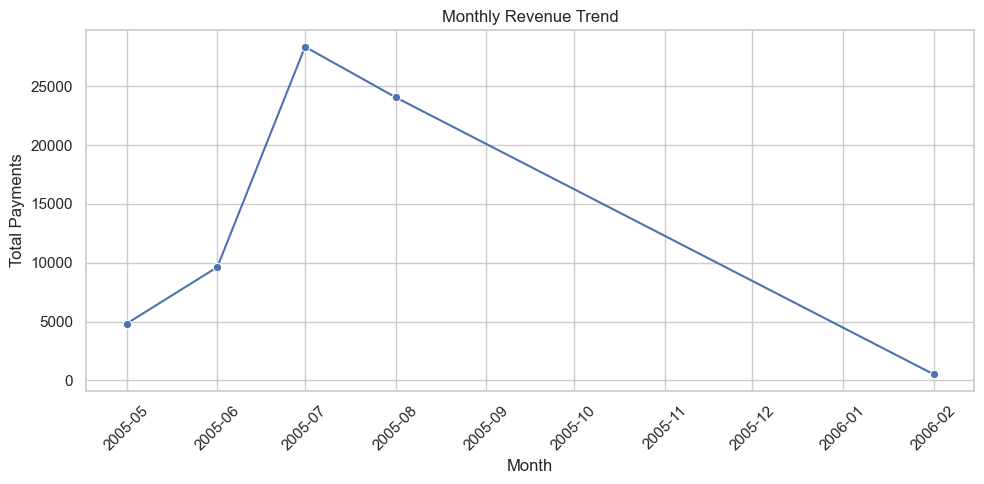

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Load monthly revenue
monthly = pd.read_sql("""
SELECT date_id, monthly_payment_total 
FROM fact_monthly_payment
""", engine)

# Convert date_id to datetime
monthly['date'] = pd.to_datetime(monthly['date_id'], format='%Y%m%d')

# Group by month and sum revenue
monthly = (
    monthly
    .groupby(monthly['date'].dt.to_period('M'))['monthly_payment_total']
    .sum()
    .reset_index()
)

# Convert period back to timestamp
monthly['date'] = monthly['date'].dt.to_timestamp()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly, x='date', y='monthly_payment_total', marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Payments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_8336\3382893794.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_films, x='total_inventory', y='title', palette='Blues_d')


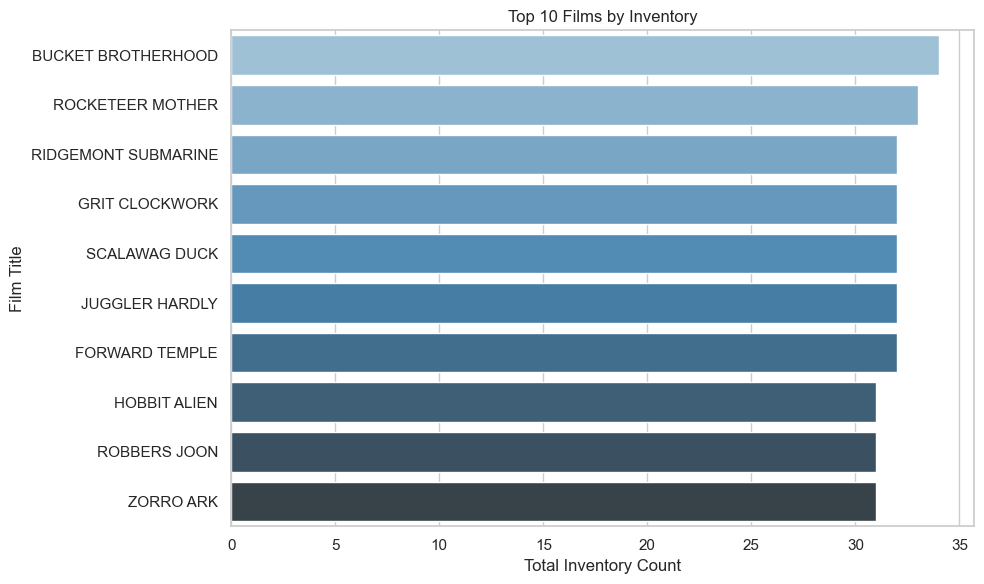

In [28]:
# Top 10 Movies by Inventory Count
top_films = pd.read_sql("""
SELECT f.title, SUM(fi.inventory_count) AS total_inventory
FROM fact_daily_inventory fi
JOIN dim_film f ON fi.film_id = f.film_id
GROUP BY f.title
ORDER BY total_inventory DESC
LIMIT 10
""", engine)

# Plot 2: Top Films
plt.figure(figsize=(10, 6))
sns.barplot(data=top_films, x='total_inventory', y='title', palette='Blues_d')
plt.title('Top 10 Films by Inventory')
plt.xlabel('Total Inventory Count')
plt.ylabel('Film Title')
plt.tight_layout()
plt.show()


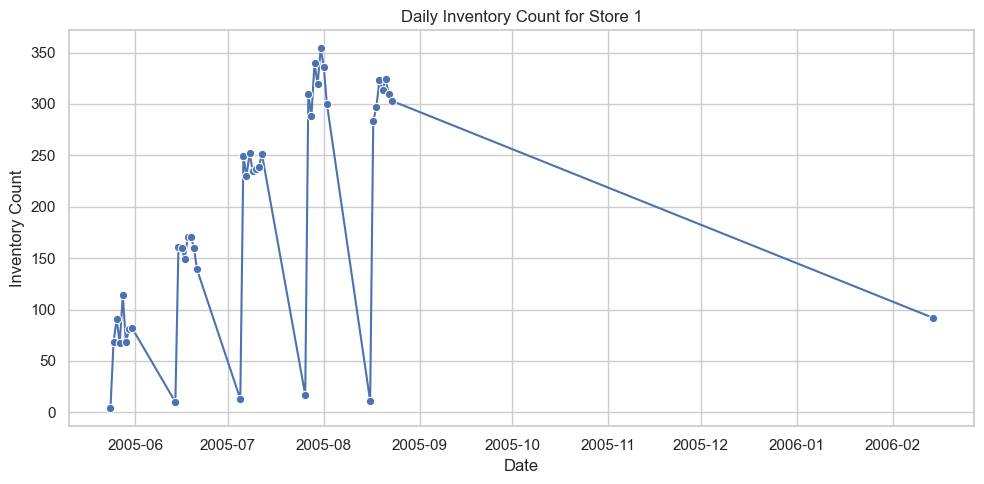

In [35]:
# Plot 3: Daily Inventory for Store 1
store_daily = pd.read_sql("""
SELECT date_id, inventory_count 
FROM fact_daily_inventory 
WHERE store_id = 1
""", engine)

store_daily['date'] = pd.to_datetime(store_daily['date_id'], format='%Y%m%d')
daily = store_daily.groupby('date').sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily, x='date', y='inventory_count', marker='o')
plt.title('Daily Inventory Count for Store 1')
plt.xlabel('Date')
plt.ylabel('Inventory Count')
plt.tight_layout()
plt.show()
